## Importación de librerías

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#importación de algoritmos y métricas para determinar la clasificación del cliente
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import functions as fnc
plt.style.use('ggplot')

#### Importación de la base de datos

In [2]:
#Importo la base de datos y elimno la columna row_id que es irrelevante
clientes = pd.read_csv('csv/data_desafio_seguros.csv').drop(columns=['row_id'])

# Renombro las columnas para hacer más afable el dataframe al momento de trabajar
clientes.rename(columns = {'0':'cuentaCorriente', '1':'meses', '2':'historiaCrediticia', '3':'propositoCredito',
                           '4':'montoCredito', '5':'ahorrosCuenta', '6':'tiempoEmpleoActual', '7':'tasaRentaDisponible',
                           '8':'estatusSexo', '9':'deudoresGarantes', '10':'tiempoResidencia', '11':'posesiones',
                           '12':'edad', '13':'otrosPagos', '14':'vivienda', '15':'numCredito', '16':'tipoTrabajo',
                           '17':'personasResponsable', '18':'telefono', '19':'trabajadorExtranjero', 
                           '20':'tipoCliente'},
                           inplace=True)
clientes.head()

,cuentaCorriente,meses,historiaCrediticia,propositoCredito,montoCredito,ahorrosCuenta,tiempoEmpleoActual,tasaRentaDisponible,estatusSexo,deudoresGarantes,...,posesiones,edad,otrosPagos,vivienda,numCredito,tipoTrabajo,personasResponsable,telefono,trabajadorExtranjero,tipoCliente
0,A12,30,A34,A40,4249,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2
1,A14,36,A32,A43,3835,A65,A75,2,A92,A101,...,A121,45,A143,A152,1,A172,1,A192,A201,1
2,A12,12,A34,A41,1804,A62,A72,3,A93,A101,...,A122,44,A143,A152,1,A173,1,A191,A201,1
3,A13,12,A31,A49,609,A61,A72,4,A92,A101,...,A121,26,A143,A152,1,A171,1,A191,A201,2
4,A12,21,A32,A49,2767,A62,A75,4,A91,A101,...,A123,61,A141,A151,2,A172,1,A191,A201,2


## EDA

__No se aprecian datos perdidos en el dataset por lo que se puede seguir trabajando sin ningún incoveniente.__

In [3]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 21 columns):
cuentaCorriente         900 non-null object
meses                   900 non-null int64
historiaCrediticia      900 non-null object
propositoCredito        900 non-null object
montoCredito            900 non-null int64
ahorrosCuenta           900 non-null object
tiempoEmpleoActual      900 non-null object
tasaRentaDisponible     900 non-null int64
estatusSexo             900 non-null object
deudoresGarantes        900 non-null object
tiempoResidencia        900 non-null int64
posesiones              900 non-null object
edad                    900 non-null int64
otrosPagos              900 non-null object
vivienda                900 non-null object
numCredito              900 non-null int64
tipoTrabajo             900 non-null object
personasResponsable     900 non-null int64
telefono                900 non-null object
trabajadorExtranjero    900 non-null object
tipoCliente           

__Recodificación de las columnas para que los valores de ellas puedan ser interpretados por los algoritmos de clasificación, para este caso, aplicaré la función `get_dummies` que se encarga de separar a todas las categorías de la columna y las agrega como atributos al dataframe (aplica sólo a columnas con más de 2 categorías), esto con el objetivo de clasificar ese dato del cliente y además borra la columna original para evitar multicolinealidad.__

In [4]:
#Recodificacion de columnas con más de 2 categorías
clientes_recod = pd.get_dummies(clientes,
                                columns=['cuentaCorriente', 'historiaCrediticia', 'propositoCredito',
                                         'ahorrosCuenta', 'tiempoEmpleoActual', 'estatusSexo', 'deudoresGarantes', 
                                         'posesiones', 'otrosPagos', 'vivienda', 'tipoTrabajo'],
                                prefix=['cuentaCorriente', 'historiaCrediticia', 'propositoCredito',
                                         'ahorrosCuenta', 'tiempoEmpleoActual', 'estatusSexo', 'deudoresGarantes', 
                                         'posesiones', 'otrosPagos', 'vivienda', 'tipoTrabajo'],
                                prefix_sep='_')

#Recodificación de columnas con 2 categorías
clientes_recod['telefono'] = np.where(clientes_recod['telefono'] == 'A192', 1, 0)
clientes_recod['trabajadorExtranjero'] = np.where(clientes_recod['trabajadorExtranjero'] == 'A201', 1, 0)
clientes_recod['tipoCliente'] = np.where(clientes_recod['tipoCliente'] == 2, 1, 0)

__No se aprecia ningna anomalía en los datos del dataset una vez recodificado.__

In [5]:
clientes_recod.describe()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,telefono,trabajadorExtranjero,tipoCliente,...,otrosPagos_A141,otrosPagos_A142,otrosPagos_A143,vivienda_A151,vivienda_A152,vivienda_A153,tipoTrabajo_A171,tipoTrabajo_A172,tipoTrabajo_A173,tipoTrabajo_A174
count,900.000000,900.000000,900.000000,900.00000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,...,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,21.093333,3276.157778,2.975556,2.85000,35.567778,1.397778,1.147778,0.410000,0.961111,0.297778,...,0.142222,0.046667,0.811111,0.180000,0.711111,0.108889,0.021111,0.200000,0.632222,0.146667
std,12.082133,2777.158770,1.115899,1.09542,11.398967,0.559671,0.355077,0.492107,0.193438,0.457536,...,0.349472,0.211041,0.391638,0.384401,0.453498,0.311673,0.143835,0.400222,0.482469,0.353970
min,4.000000,250.000000,1.000000,1.00000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1382.000000,2.000000,2.00000,27.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18.000000,2328.000000,3.000000,3.00000,33.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,24.000000,3994.000000,4.000000,4.00000,42.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,72.000000,18424.000000,4.000000,4.00000,75.000000,4.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


El vector objetivo ('tipoCliente') se encuentra desbalanceado, debido a que la ` clase 0: Bueno` consta de un __70.22%__ y la  `clase 1: Malo` representa un __29.78%__, a pesar de esto tomaré como métrica de medición `f1-score` donde se puede apreciar la medición para ambas clases y saber con mayor exactitud que tan bien reconoce el modelo las clases `0 y 1`.

In [6]:
clientes_recod['tipoCliente'].value_counts('%')

0    0.702222
1    0.297778
Name: tipoCliente, dtype: float64

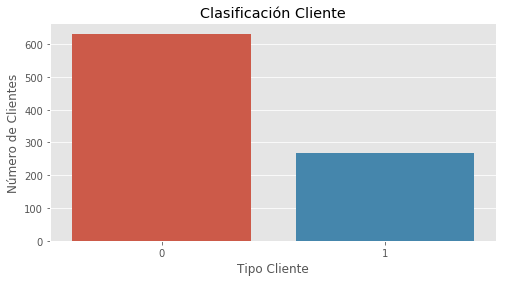

In [7]:
plt.figure(figsize=(8,4))
sns.countplot(x='tipoCliente', data=clientes_recod)
plt.xlabel("Tipo Cliente")
plt.ylabel("Número de Clientes")
plt.title("Clasificación Cliente")
plt.savefig("clasificacionCliente");

## Implementación de Algoritmos y técnicas de mejoras para la clasificación de los clientes

In [8]:
#Separo mi data en matrices de entrenamiento y validación
X = clientes_recod.drop(columns=['tipoCliente'])
Y = clientes_recod.pop('tipoCliente')

#Genero las matrices de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.33, random_state=123)

### Creación de los 5 modelos:
Para este caso voy a implementar __5 modelos de Clasificación__, en cada uno de ellos haré una implementación `Vanilla` para ver su desempeño y posteriormente haré un ajuste de hiperparametros `GridSearch` para hacer más robusto al modelo. Al final veré que modelo tiene un mejor desempeño y lo tomaré para aplicar los cálculos pertinentes al dataset de test `X_test`. A continuación se presentan los modelos a utilizar. 

1. XGBoost
2. SVC
3. Naive Bayes
4. Logistic Regression
5. Random Forest

#### 1.- XGBoost

__1.1.- Implementación del Modelo__

In [9]:
model_xgb = XGBClassifier().fit(X_train, y_train)
model_xgb_pred = model_xgb.predict(X_test)

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Este modelo presenta una predicción promedio del __69%__ para ambas clases, donde predice de mejor manera la `clase 0` y para la `clase 1` con un porcetaje por debajo, por otra parte presenta una precisión mejor para la `clase 0` de un __73%__ y para la `clase 1` de un __65%.__

In [10]:
print(classification_report(y_test, model_xgb_pred))

             precision    recall  f1-score   support

          0       0.73      0.89      0.80       193
          1       0.65      0.39      0.49       104

avg / total       0.70      0.71      0.69       297



__1.2.- Ajustes de Hiperparametros__

Ahora haré un `GridSearch` para encontrar los mejores hiperparamentros en mi modelo y poder mejorar su desempeño.

In [11]:
#Implementación GridSearch
n_estimators = [50, 100, 150, 200, 500]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
grid_search = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
result_xgb = grid_search.fit(X_train, y_train)

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

In [12]:
print("Best Scoring: %f using:%s" %(result_xgb.best_score_, result_xgb.best_params_))

Best Scoring: 0.777778 using:{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 150}


In [13]:
model_xgb_cv = XGBClassifier(learning_rate=0.3, max_depth=8, n_estimators=150, subsample=0.80)
model_xgb_cv = model_xgb_cv.fit(X_train, y_train)

model_xgb_cv_pred = model_xgb_cv.predict(X_test)

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Una vez ajustados los hiperparametros en el modelo, su desempeñado ha mejorado un poco tanto en la predicción en cada clase como en la precisión de cada una de ellas, teniendo como predicción general de un __71%__. Acá se puede apreciar en valores y gráficas las métricas.

In [14]:
print(classification_report(y_test, model_xgb_cv_pred))

             precision    recall  f1-score   support

          0       0.74      0.89      0.81       193
          1       0.68      0.43      0.53       104

avg / total       0.72      0.73      0.71       297



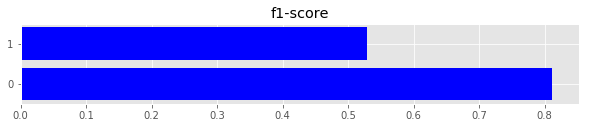

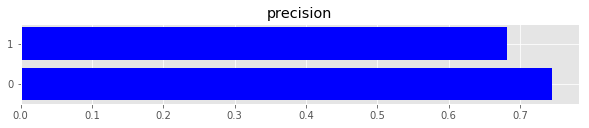

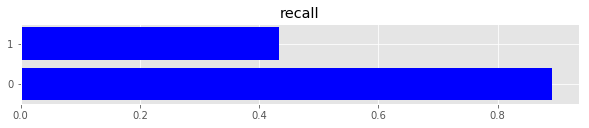

In [15]:
fnc.class_report(y_test, model_xgb_cv_pred)

Para este modelo nuestra `ROC Curve` es del __72%__ lo que significa que su desempeño es un __22%__ por encima del clasificador análitico en este caso es del __50%__ ya que estamos trabajando con 2 clases.

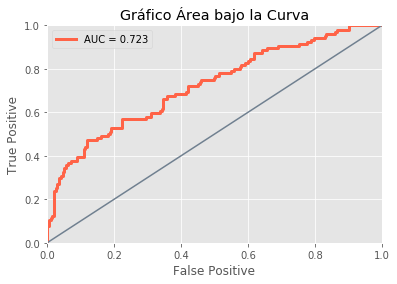

In [16]:
#ROC Curve como métrica del área bajo la curva
model_xgb_prob = model_xgb_cv.predict_proba(X_test)[:, 1]

#ROC Curve
fpr, tpr, _ = roc_curve(y_test, model_xgb_prob)

#Obtener área debajo la curva
auc = round(roc_auc_score(y_test, model_xgb_prob), 3)

#Grafico del área bajo la curva
plt.plot(fpr, tpr, label='AUC = {}'.format(auc), color='tomato', ls='-', lw=3)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.axis([0, 1, 0, 1])
#Gráfico del clasificador por chance
plt.plot([0, 1], [0, 1], color='slategrey', ls='-')
plt.legend()
plt.title("Gráfico Área bajo la Curva");

#### 2.- SVC

__2.1.- Implementación del Modelo__

In [17]:
model_svc = SVC(probability=True).fit(X_train, y_train)
model_svc_pred = model_svc.predict(X_test)

Este modelo tiene un desempeño no muy alentador para lo que queremos resolver, su predicción general es del __51%__, por otra parte predice de manera aceptable a la `clase 0` pero ningún porcentaje para la `clase 1`.

In [18]:
print(classification_report(y_test, model_svc_pred))

             precision    recall  f1-score   support

          0       0.65      0.99      0.79       193
          1       0.00      0.00      0.00       104

avg / total       0.42      0.65      0.51       297



__2.2.- Ajustes de Hiperparametros__

In [19]:
#GridSearch
c= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = dict(C=c, gamma=gamma)
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
result_svc = grid_search.fit(X_train, y_train)

In [20]:
print("Best Scoring: %f using: %s" %(result_svc.best_score_, result_svc.best_params_))

Best Scoring: 0.731343 using: {'C': 100, 'gamma': 1e-07}


In [21]:
model_svc_cv = SVC(C=100, gamma=0.0000001, probability=True)
model_svc_cv = model_svc_cv.fit(X_train, y_train)

model_svc_cv_pred = model_svc_cv.predict(X_test)

El desempeño para este modelo no es nada alentador, debido a que no predice bien a la `clase 1: Malo` aún así con los hiperparametros ajustados.

In [22]:
print(classification_report(y_test, model_svc_cv_pred))

             precision    recall  f1-score   support

          0       0.65      0.96      0.78       193
          1       0.30      0.03      0.05       104

avg / total       0.53      0.64      0.52       297



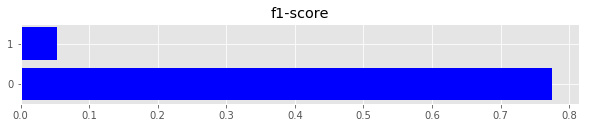

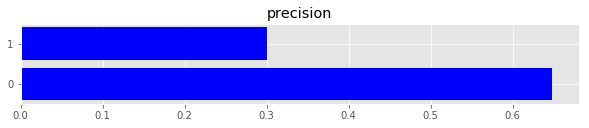

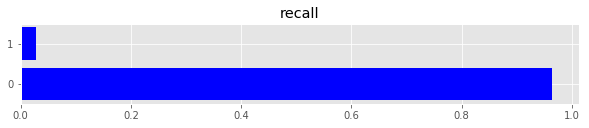

In [23]:
fnc.class_report(y_test, model_svc_cv_pred)

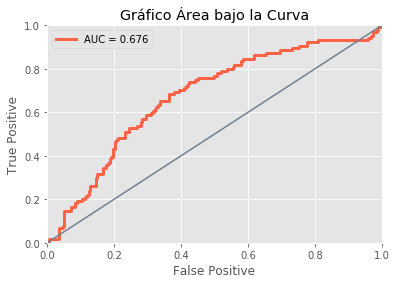

In [24]:
#ROC Curve como métrica del área bajo la curva
model_svc_prob = model_svc_cv.predict_proba(X_test)[:, 1]

#ROC Curve
fpr, tpr, _ = roc_curve(y_test, model_svc_prob)

#Obtener área debajo la curva
auc = round(roc_auc_score(y_test, model_svc_prob), 3)

#Grafico del área bajo la curva
plt.plot(fpr, tpr, label='AUC = {}'.format(auc), color='tomato', ls='-', lw=3)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.axis([0, 1, 0, 1])
#Gráfico del clasificador por chance
plt.plot([0, 1], [0, 1], color='slategrey', ls='-')
plt.legend()
plt.title("Gráfico Área bajo la Curva");

#### 3.- Naive Bayes

__3.1.- Implementación del Modelo__

In [25]:
model_nb = BernoulliNB().fit(X_train, y_train)
model_nb_pred = model_nb.predict(X_test)

Este modelo tiene un desempeño del para la predicción general del __71%__, para la `clase 0` tiene una predicción de casi el __80%__ y para la `clase 1` de un __55%__, para hacer mejoras a este tipo de algoritmo es recomendable implementar un modelo `ensamble`posteriormente implementaré un `RandomForest` para ver si mejora. 

In [26]:
print(classification_report(y_test, model_nb_pred))

             precision    recall  f1-score   support

          0       0.75      0.83      0.79       193
          1       0.61      0.49      0.55       104

avg / total       0.70      0.71      0.71       297



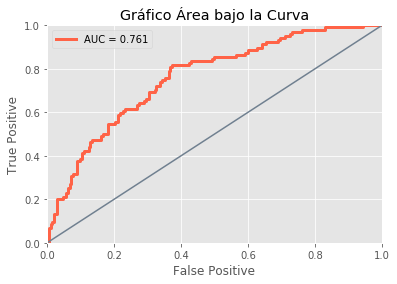

In [27]:
#ROC Curve como métrica del área bajo la curva
model_nb_prob = model_nb.predict_proba(X_test)[:, 1]

#ROC Curve
fpr, tpr, _ = roc_curve(y_test, model_nb_prob)

#Obtener área debajo la curva
auc = round(roc_auc_score(y_test, model_nb_prob), 3)

#Grafico del área bajo la curva
plt.plot(fpr, tpr, label='AUC = {}'.format(auc), color='tomato', ls='-', lw=3)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.axis([0, 1, 0, 1])
#Gráfico del clasificador por chance
plt.plot([0, 1], [0, 1], color='slategrey', ls='-')
plt.legend()
plt.title("Gráfico Área bajo la Curva");

El área bajo la curva es de un __76%__, lo que significa que el modelo tiene un desempeño del __26%__ superior, para clasificar al azar una observación de manera correcta. 

#### 4.- Logistic Regression

__4.1.- Implementación del Modelo__

In [28]:
model_log = LogisticRegression().fit(X_train, y_train)
model_log_pred = model_log.predict(X_test)

`Logistic Regression` tiene un desempeño del __71%__ en predicciones, para la `clase 0` posee un desempeño aceptable y la `clase 1` un poco menos, en cuanto a la precisión son porcentajes aceptables dado la cantidad de observaciones del dataframe. 

In [29]:
print(classification_report(y_test, model_log_pred))

             precision    recall  f1-score   support

          0       0.75      0.88      0.81       193
          1       0.67      0.44      0.53       104

avg / total       0.72      0.73      0.71       297



__4.2.- Ajustes de Hiperparametros__

In [30]:
#GridSearch
penalty = ['l1', 'l2']
C = np.logspace(0, 1, 5)
fit_intercept = ['True', 'False']
param_grid = dict(penalty=penalty, C=C, fit_intercept=fit_intercept)
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
result_log = grid_search.fit(X_train, y_train)

In [31]:
print("Best Scoring: %f using:%s" %(result_log.best_score_, result_log.best_params_))

Best Scoring: 0.774461 using:{'C': 1.0, 'fit_intercept': 'True', 'penalty': 'l1'}


In [32]:
model_log_cv = LogisticRegression(C=1.0, fit_intercept=True, penalty='l1')
model_log_cv = model_log_cv.fit(X_train, y_train)

model_log_cv_pred = model_log_cv.predict(X_test)

Una vez ajustados los hiperparametros el desempeño decreció un __1%__ en las predicciones generales, y un poco en la precisión de la `clase 1` el beneficio es que el modelo es mucho más robusto. Abajo se aprecian los números y los gráficos de las métricas.

In [33]:
print(classification_report(y_test, model_log_cv_pred))

             precision    recall  f1-score   support

          0       0.74      0.89      0.80       193
          1       0.66      0.41      0.51       104

avg / total       0.71      0.72      0.70       297



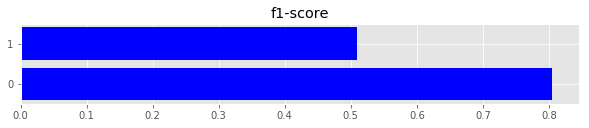

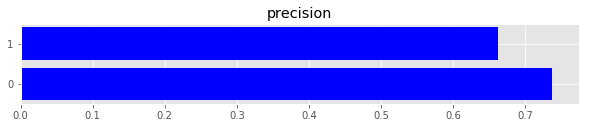

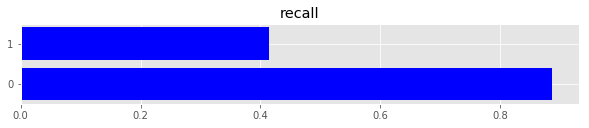

In [34]:
fnc.class_report(y_test, model_log_cv_pred)

Su desempeño en `ROC Curve` es del __74%__, lo lo que significa que tiene un __24%__ más al momento de predecir una observación al azar con respecto al clasificador análitico que es del __50%__ ya que estamos trabajando con 2 clases. 

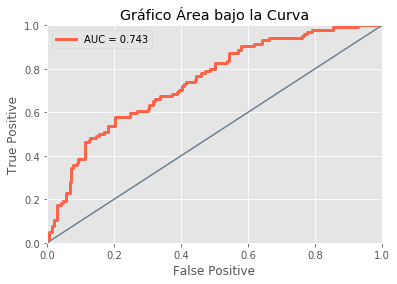

In [35]:
#ROC Curve como métrica del área bajo la curva
model_log_prob = model_log_cv.predict_proba(X_test)[:, 1]

#ROC Curve
fpr, tpr, _ = roc_curve(y_test, model_log_prob)

#Obtener área debajo la curva
auc = round(roc_auc_score(y_test, model_log_prob), 3)

#Grafico del área bajo la curva
plt.plot(fpr, tpr, label='AUC = {}'.format(auc), color='tomato', ls='-', lw=3)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.axis([0, 1, 0, 1])
#Gráfico del clasificador por chance
plt.plot([0, 1], [0, 1], color='slategrey', ls='-')
plt.legend()
plt.title("Gráfico Área bajo la Curva");

#### 5.- RandomForest

__5.1.- Implementación del Modelo__

In [36]:
model_rf = RandomForestClassifier().fit(X_train, y_train)
model_rf_pred = model_rf.predict(X_test)

Implementado un `Modelo Ensemble` obtenemos un desempeño del __63%__ para predecir en línea general, en las predicciones por clases es aceptable para la `clase 0` pero no tiene un buen desempeño para la `clase 1`, ajustaré los hiperparametros para ver si el modelo ha mejorado.

In [37]:
print(classification_report(y_test, model_rf_pred))

             precision    recall  f1-score   support

          0       0.71      0.95      0.81       193
          1       0.76      0.28      0.41       104

avg / total       0.73      0.72      0.67       297



__5.2.- Ajustes de Hiperparametros__

In [38]:
#Listas para guardar los valores temporales
tmp_oob_none, tmp_oob_sqrt, tmp_oob_log2 = [], [], []
n_estimators = range(5, 100, 20)

In [39]:
#Evaluación de los n_estimators
for i in n_estimators:
    #Implementamos una variante con todos los atributos
    rf_none = RandomForestClassifier(n_estimators=i, max_features=None,
                                     oob_score=True,
                                     random_state=123).fit(X_train, y_train)
    
    #Implementamos una variante donde los atributos se escogen con sqrt
    rf_sqrt = RandomForestClassifier(n_estimators=i, max_features='sqrt',
                                     warm_start=True,
                                     oob_score=True,
                                     random_state=123).fit(X_train, y_train)
    
    #Implementamos una variante donde los atributos se escogen con log2
    rf_log = RandomForestClassifier(n_estimators=i, max_features='log2',
                                    warm_start=True,
                                    oob_score=True,
                                   random_state=123).fit(X_train, y_train)
    
    tmp_oob_none.append(1 - rf_none.oob_score)
    tmp_oob_sqrt.append(1 - rf_sqrt.oob_score)
    tmp_oob_log2.append(1 - rf_log.oob_score)

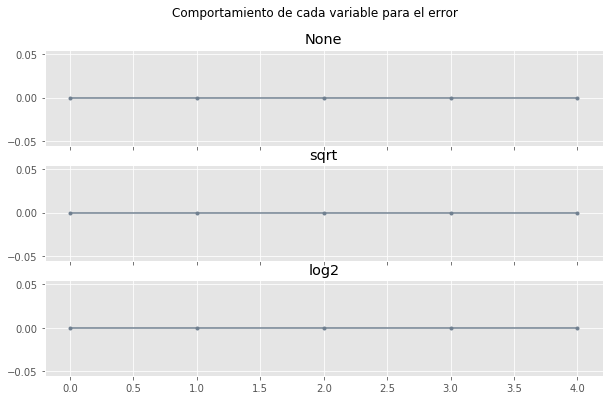

In [40]:
#Graficamos el comportamiento de cada cariable
fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True, sharey=True)

ax1 = axs[0]
ax1.plot(tmp_oob_none, '.-', color='slategrey', label='OOB None')
ax1.set_title("None")

ax2 = axs[1]
ax2.plot(tmp_oob_sqrt, ".-", color='slategrey', label='OOB sqrt')
ax2.set_title("sqrt")

ax3 = axs[2]
ax3.plot(tmp_oob_log2, ".-", color='slategrey', label="OOB log2")
ax3.set_title("log2")

fig.suptitle("Comportamiento de cada variable para el error");

In [41]:
model_rf_cv = RandomForestClassifier(max_features='log2')
model_rf_cv = model_rf_cv.fit(X_train, y_train)

model_rf_cv_pred = model_rf_cv.predict(X_test)

Una vez hecho los ajustes a los hiperpametros el modelo mejoró su desempeño pero no como esperaba, si bien predice a la `clase 0` con un aceptable porcentaje, ocurre todo lo contrario para la `clase 1` debido a que está por debajo del __50%__, sus precisiones tienen buenos valores de __70%__ y un poco más.

In [42]:
print(classification_report(y_test, model_rf_cv_pred))

             precision    recall  f1-score   support

          0       0.71      0.94      0.81       193
          1       0.72      0.27      0.39       104

avg / total       0.71      0.71      0.66       297



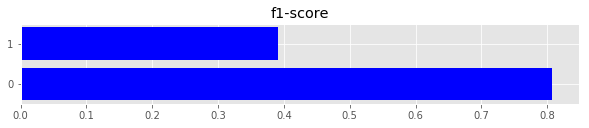

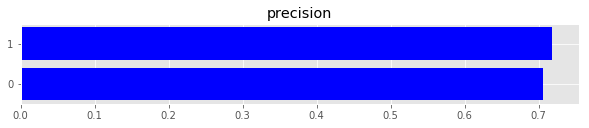

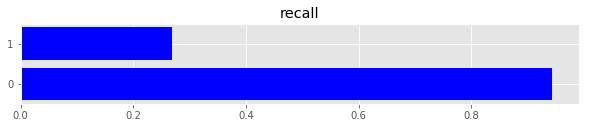

In [43]:
fnc.class_report(y_test, model_rf_cv_pred)

## Cálculo de la Predicción y la Probabilidad en el dataframe `X_test`

Por último, haré los cálculos pertinentes para saber el `Precio base del seguro por persona = (3*(1+0.03+p))UF` donde __p=(0.1* score de riesgo)__ , el __score de riesgo__ es igual a la probabilidad de que ese cliente haya sido clasificado como `Bueno o Malo`. 

Para obtener dicha __probabilidad (score de riesgo)__ implementaré el algoritmo de `XGBoost` ya que fue el de mejor desempeño en la batería de algoritmos que implemeté, teniendo un __71%__ en predicción general al momento de clasificar un cliente y un desempeño aceptable en `ROC Curve` también. 

__Nota: Para mejorar la predicción en la `clase 1` en los diferentes algoritmos es necesario obtener más datos para que el modelo puedo entender mucho más a los clientes de este tipo y aumentar el porcentaje de predicción. Como mencioné en un principio la data en el vector objetivo se encuentra desbalanceada.__

In [44]:
#Hago una copia de mi dataset de prueba
df_test = X_test.copy()

In [45]:
#Obtengo el valor 'tipoCliente' (es el que identifica si el cliente es Bueno o Malo)
tipo_cliente = model_xgb_cv.predict(df_test)

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [46]:
#Obtengo el 'scoreRiesgo' (probabilidad con la que el client fue clasificado 
#como Bueno o Malo)
score_riesgo = model_xgb_cv.predict_proba(df_test)[:, 1]

In [47]:
#Agrego cada uno de esos valores al dataframe como columnas,
#acá el cliente es clasificado como 0 y 1, además, se aprecia
#la probabilidad 
df_test['tipoCliente'] = tipo_cliente
df_test['scoreRiesgo'] = score_riesgo

In [48]:
#Vista completa al dataframe 
df_test.head()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,telefono,trabajadorExtranjero,cuentaCorriente_A11,...,otrosPagos_A143,vivienda_A151,vivienda_A152,vivienda_A153,tipoTrabajo_A171,tipoTrabajo_A172,tipoTrabajo_A173,tipoTrabajo_A174,tipoCliente,scoreRiesgo
613,20,4272,1,4,24,2,1,0,1,1,...,1,0,1,0,0,0,1,0,0,0.260895
524,18,1216,4,3,23,1,1,1,1,1,...,1,1,0,0,0,0,1,0,1,0.878854
690,24,2896,2,1,29,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,0.138012
457,18,1530,3,2,32,2,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0.375768
85,15,1403,2,4,28,1,1,0,1,1,...,1,1,0,0,0,0,1,0,1,0.975218


In [49]:
#Valor UF y cálculo de p 
UF = 27585.39
p = (0.1 * df_test['scoreRiesgo'])

#Cálculo del precio base del seguro por persona
#de acuerdo a fórmula en el PDF
df_test['precioSeguro'] = (3 * (1 + 0.03 + p)) * UF

In [50]:
#Redondeo a 2 decimales el valor del precio seguro por cliente
df_test['precioSeguro'] = df_test['precioSeguro'].apply(lambda x: round(x, 2))

In [51]:
#Vista completa del dataframe, donde se aprecia, si el cliente es Bueno o Malo (0, 1) respectivamente
#la probabilidad por la cual fue clasificado de esa manera el cliente y por último el precio del 
#seguro que ese cliente debe pagar de acuerdo a sus características como cliente.
df_test.head()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,telefono,trabajadorExtranjero,cuentaCorriente_A11,...,vivienda_A151,vivienda_A152,vivienda_A153,tipoTrabajo_A171,tipoTrabajo_A172,tipoTrabajo_A173,tipoTrabajo_A174,tipoCliente,scoreRiesgo,precioSeguro
613,20,4272,1,4,24,2,1,0,1,1,...,0,1,0,0,0,1,0,0,0.260895,87397.93
524,18,1216,4,3,23,1,1,1,1,1,...,1,0,0,0,0,1,0,1,0.878854,92511.91
690,24,2896,2,1,29,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0.138012,86380.98
457,18,1530,3,2,32,2,1,0,1,0,...,0,1,0,0,0,1,0,0,0.375768,88348.56
85,15,1403,2,4,28,1,1,0,1,1,...,1,0,0,0,0,1,0,1,0.975218,93309.38


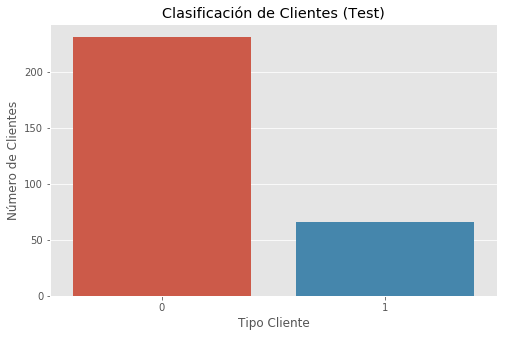

In [52]:
plt.figure(figsize=(8, 5))
sns.countplot(x='tipoCliente', data=df_test)
plt.xlabel("Tipo Cliente")
plt.ylabel("Número de Clientes")
plt.title("Clasificación de Clientes (Test)")
plt.savefig("clasificacion_clientes_df_test");

In [53]:
df_test.to_csv('csv/precio_seguro.csv', header=True, index=False)